# Lab 4:  Data preprocessing

We explore the performance of several linear regression models on a real-world dataset, i.e. [MoneyBall](https://www.openml.org/d/41021). See the description on OpenML for more information. In short, this dataset captures performance data from baseball players. The regression task is to accurately predict the number of 'runs' each player can score, and understanding which are the most important factors.

In [1]:
!pip install openml


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns

In [3]:
# Download MoneyBall data from OpenML
moneyball = oml.datasets.get_dataset(41021)
# Get the pandas dataframe (default)
X, y, _, attribute_names = moneyball.get_data(target=moneyball.default_target_attribute)

## Exploratory analysis and visualization
First, we visually explore the data by visualizing the value distribution and the interaction between every other feature in a scatter matrix. We use the target feature as the color variable to see which features are correlated with the target.

For the plotting to work, however, we need to remove the categorical features (the first 2) and fill in the missing values. Let's find out which columns have missing values. This matches what we already saw on the OpenML page (https://www.openml.org/d/41021).

In [4]:
pd.isnull(X).any()

Team            False
League          False
Year            False
RA              False
W               False
OBP             False
SLG             False
BA              False
Playoffs        False
RankSeason       True
RankPlayoffs     True
G               False
OOBP             True
OSLG             True
dtype: bool

For this first quick visualization, we will simply impute the missing values using the median. Removing all instances with missing values is not really an option since some features have consistent missing values: we would have to remove a lot of data.

In [5]:
# Impute missing values with sklearn and rebuild the dataframe
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_clean_array = imputer.fit_transform(X[attribute_names[2:]]) # skip the first 2 features
# The imputer will return a numpy array. To plot it we make it a pandas dataframe again.
X_clean = pd.DataFrame(X_clean_array, columns = attribute_names[2:]) #

Next, we build the scatter matrix. We include the target column to see which features strongly correlate with the target, and also use the target value as the color to see which combinations of features correlate with the target.

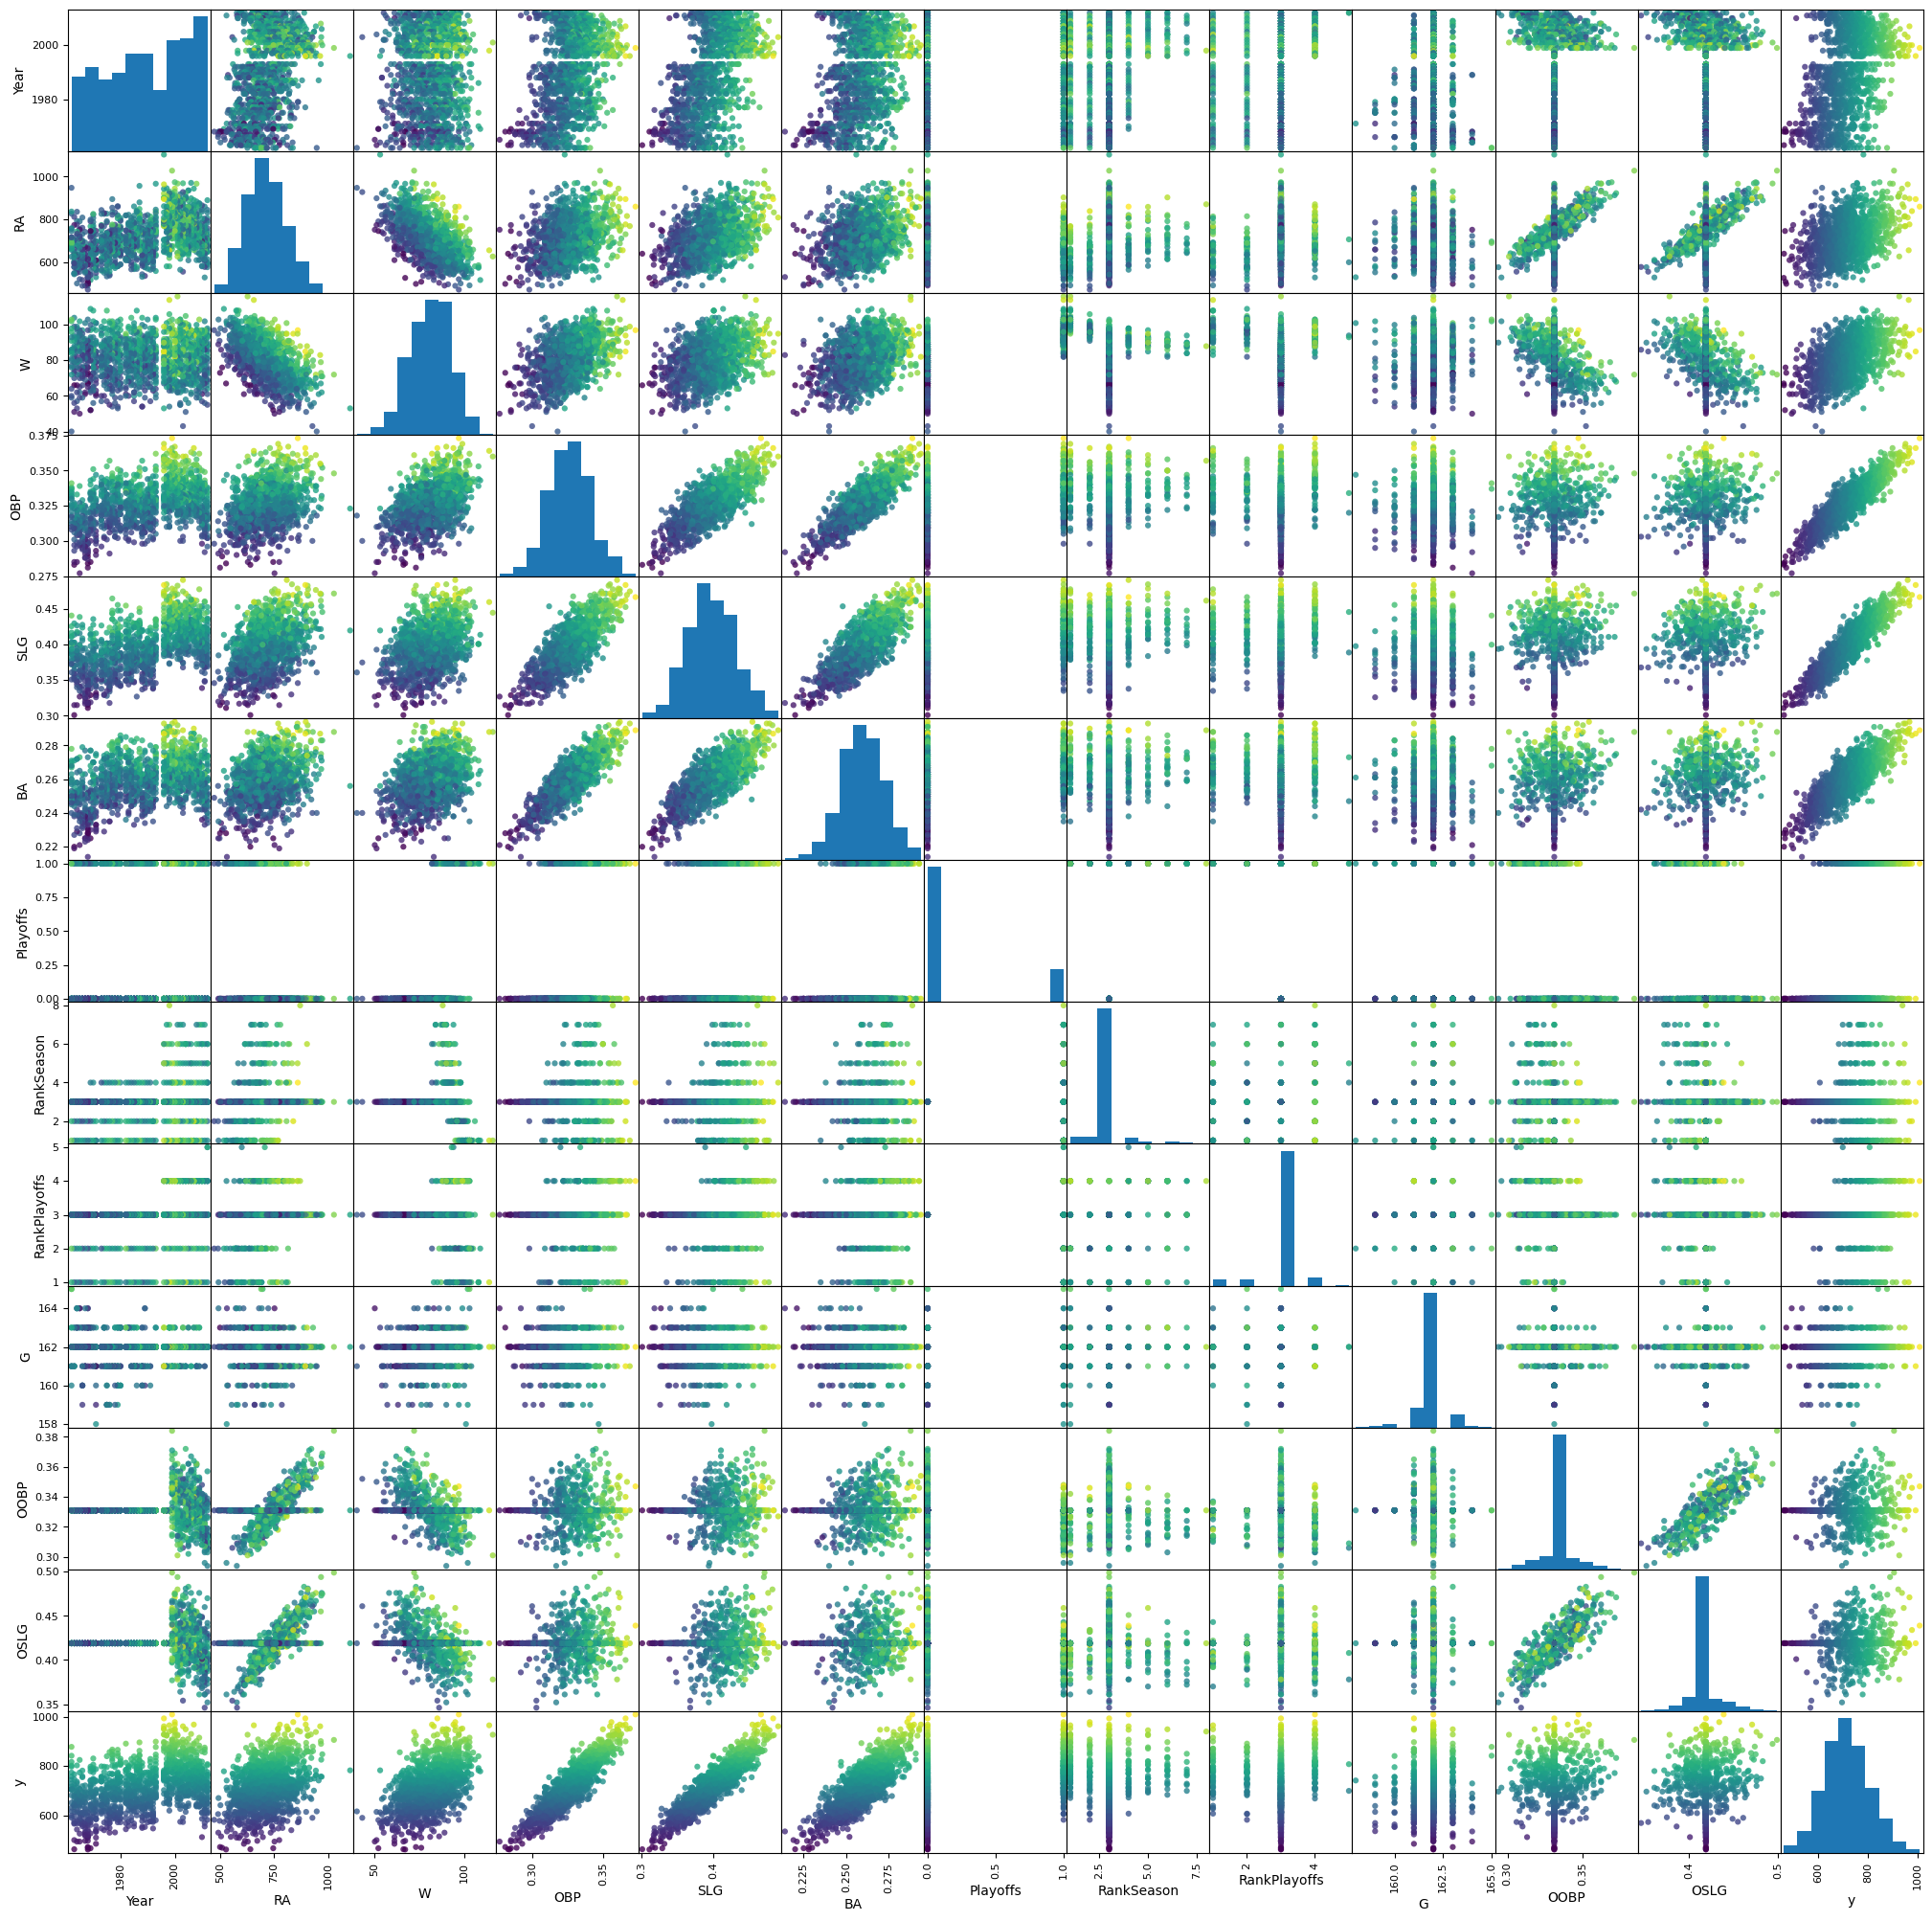

In [6]:
from pandas.plotting import scatter_matrix

# Scatter matrix of dataframe including the target feature
copyframe = X_clean.copy() 
copyframe['y'] = pd.Series(y, index=copyframe.index)
scatter_matrix(copyframe, c=y, figsize=(25,25), 
               marker='o', s=20, alpha=.8, cmap='viridis');

Several things immediately stand out:
* OBP, SLG and BA strongly correlate with the target (near-diagonals in the final column), but also combinations of either of these and W or R seem useful.
* RA, W, OBP, SLG and BA seem normally distributed, most others do not. 
* OOBP and OSLG have a very peaked distribution. 
* 'Playoffs' seems to be categorical and should probably be encoded as such. 

## Exercise 1: Build a pipeline

Implement a function `build_pipeline` that does the following:
- Impute missing values by replacing NaN's with the feature median for numerical features.
- Encode the categorical features using OneHotEncoding.
- If the attribute `scaling=True`, also scale the data using standard scaling.
- Attach the given regression model to the end of the pipeline

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

def build_pipeline(model, scaling=True, categorical_features=None, numerical_features=None):
    """
    Build a robust pipeline with the given regression model
    
    Keyword arguments:
    regressor -- the regression model
    categorical -- the list of categorical features
    scaling -- whether or not to scale the data
    
    Returns: a pipeline
    """
    
    if categorical_features is None or numerical_features is None:
        raise ValueError("Необходимо указать списки категориальных и числовых признаков")
    
    # Обработка числовых признаков
    num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Заполнение пропущенных значений медианой
        ('scaler', StandardScaler()) if scaling else ('passthrough', 'passthrough')  # Масштабирование данных
    ])
    
    # Обработка категориальных признаков
    cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропущенных значений наиболее частым значением
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Кодирование категориальных данных
    ])
    
    # Объединение обработки признаков
    preprocessor = ColumnTransformer([
        ('num', num_transformer, numerical_features),
        ('cat', cat_transformer, categorical_features)
    ])
    
    # Полный конвейер
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Этап предварительной обработки
        ('model', model)  # Добавление модели регрессии
    ])
    
    return pipeline

## Exercise 2: Test the pipeline
Test the pipeline by evaluating linear regression (without scaling) on the dataset, using 5-fold cross-validation and $R^2$. Make sure to run it on the original dataset ('X'), not the manually cleaned version ('X_clean').

In [19]:
# Тестирование конвейера
from sklearn.datasets import fetch_openml

def test_pipeline():
    """
    Тестирование конвейера с линейной регрессией без масштабирования, используя 5-кратную кросс-валидацию и метрику R^2.
    """
    # Загрузка данных MoneyBall
    moneyball = fetch_openml(data_id=41021, as_frame=True)
    X, y = moneyball.data, moneyball.target
    
    # Определение категориальных и числовых признаков
    categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    
    # Создание и тестирование конвейера
    model = LinearRegression()
    pipeline = build_pipeline(model, scaling=False, categorical_features=categorical_features, numerical_features=numerical_features)
    
    # 5-кратная кросс-валидация
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')
    
    print(f'Средний R^2: {np.mean(scores):.4f}, стандартное отклонение: {np.std(scores):.4f}')
    return scores

# Запуск теста
test_pipeline()

Средний R^2: 0.9463, стандартное отклонение: 0.0039


array([0.94160257, 0.94814535, 0.94282783, 0.94644551, 0.95255057])

## Exercise 3: A first benchmark
Evaluate the following algorithms in their default settings, both with and without scaling, and interpret the results:  
- Linear regression
- Ridge
- Lasso
- SVM (RBF)
- RandomForests
- GradientBoosting

In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def test_models():
    """
    Тестирование различных моделей регрессии с и без масштабирования, используя 5-кратную кросс-валидацию и метрику R^2.
    """
    # Загрузка данных MoneyBall
    moneyball = fetch_openml(data_id=41021, as_frame=True)
    X, y = moneyball.data, moneyball.target
    
    # Определение категориальных и числовых признаков
    categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'SVM (RBF)': SVR(),
        'Random Forest': RandomForestRegressor(),
        'Gradient Boosting': GradientBoostingRegressor()
    }
    
    results = {}
    for name, model in models.items():
        for scaling in [False, True]:
            pipeline = build_pipeline(model, scaling=scaling, categorical_features=categorical_features, numerical_features=numerical_features)
            cv = KFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')
            results[f'{name} (Scaling={scaling})'] = (np.mean(scores), np.std(scores))
    
    for model, (mean_r2, std_r2) in results.items():
        print(f'{model}: Средний R^2 = {mean_r2:.4f}, стандартное отклонение = {std_r2:.4f}')
    
    return results

# Запуск теста
test_models()


Linear Regression (Scaling=False): Средний R^2 = 0.9463, стандартное отклонение = 0.0039
Linear Regression (Scaling=True): Средний R^2 = 0.9465, стандартное отклонение = 0.0038
Ridge (Scaling=False): Средний R^2 = 0.8776, стандартное отклонение = 0.0087
Ridge (Scaling=True): Средний R^2 = 0.9465, стандартное отклонение = 0.0039
Lasso (Scaling=False): Средний R^2 = 0.8566, стандартное отклонение = 0.0088
Lasso (Scaling=True): Средний R^2 = 0.9445, стандартное отклонение = 0.0055
SVM (RBF) (Scaling=False): Средний R^2 = -0.0050, стандартное отклонение = 0.0101
SVM (RBF) (Scaling=True): Средний R^2 = 0.6406, стандартное отклонение = 0.0164
Random Forest (Scaling=False): Средний R^2 = 0.9268, стандартное отклонение = 0.0044
Random Forest (Scaling=True): Средний R^2 = 0.9257, стандартное отклонение = 0.0047
Gradient Boosting (Scaling=False): Средний R^2 = 0.9384, стандартное отклонение = 0.0066
Gradient Boosting (Scaling=True): Средний R^2 = 0.9383, стандартное отклонение = 0.0063


{'Linear Regression (Scaling=False)': (np.float64(0.9463143665989125),
  np.float64(0.003914510037921419)),
 'Linear Regression (Scaling=True)': (np.float64(0.9464644978316057),
  np.float64(0.003759766777600331)),
 'Ridge (Scaling=False)': (np.float64(0.8776165893954557),
  np.float64(0.008716345614706163)),
 'Ridge (Scaling=True)': (np.float64(0.9464831669710071),
  np.float64(0.003882428987004677)),
 'Lasso (Scaling=False)': (np.float64(0.856633943640235),
  np.float64(0.008849804596741978)),
 'Lasso (Scaling=True)': (np.float64(0.944474337400554),
  np.float64(0.005450750661745507)),
 'SVM (RBF) (Scaling=False)': (np.float64(-0.005044132263269519),
  np.float64(0.010055263705222887)),
 'SVM (RBF) (Scaling=True)': (np.float64(0.640601072403809),
  np.float64(0.016396696812430084)),
 'Random Forest (Scaling=False)': (np.float64(0.9268184369629878),
  np.float64(0.004439580361287866)),
 'Random Forest (Scaling=True)': (np.float64(0.9256534937918612),
  np.float64(0.004711390817292136)

## Exercise 4: Tuning linear models
Next, visualize the effect of the alpha regularizer for Ridge and Lasso. Vary alpha from 1e-4 to 1e6 and plot the $R^2$ score as a line plot (one line for each algorithm). Always use scaling. Interpret the results.

c:\Users\MTS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23360.93979939929, tolerance: 822.0458777664975
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\MTS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5600.829600242898, tolerance: 810.8769640609137
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\MTS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17319.13411405898, tolerance: 826.4698722109532
  model = cd_fast.sparse_enet_coordinate_descent(
c:\U

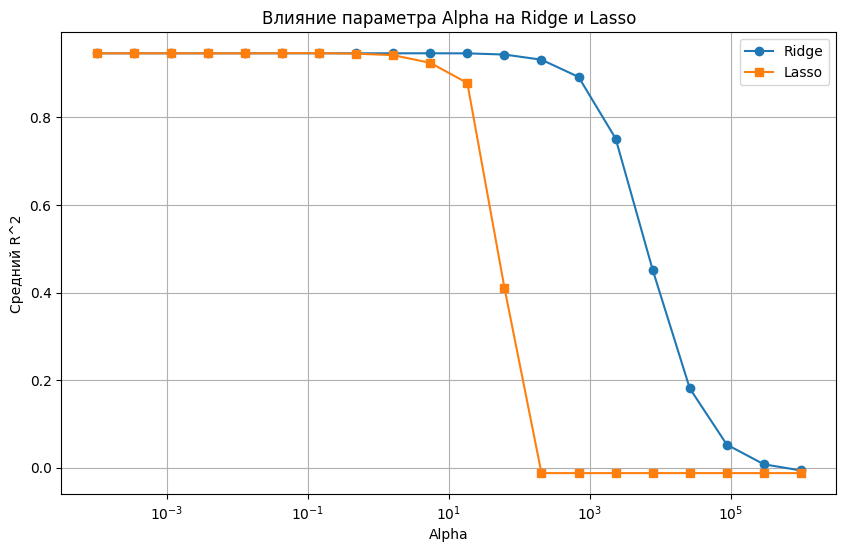

([np.float64(0.9464430038761927),
  np.float64(0.9464455744195087),
  np.float64(0.9464605520301715),
  np.float64(0.9464526454592008),
  np.float64(0.9464721163093202),
  np.float64(0.946464258211714),
  np.float64(0.9464842263690774),
  np.float64(0.9464886475131976),
  np.float64(0.946465950224501),
  np.float64(0.9465516945326637),
  np.float64(0.9463503654702171),
  np.float64(0.9436784833904053),
  np.float64(0.9318905193671505),
  np.float64(0.8925499016996972),
  np.float64(0.7518701860188),
  np.float64(0.45171193089471684),
  np.float64(0.18111100181846376),
  np.float64(0.05273022375868619),
  np.float64(0.007876055835654362),
  np.float64(-0.006160300803265284)],
 [np.float64(0.9464948827534065),
  np.float64(0.9464957262766287),
  np.float64(0.9465044953274928),
  np.float64(0.9464866229505466),
  np.float64(0.9464149692426347),
  np.float64(0.9467125168007907),
  np.float64(0.9469034289364417),
  np.float64(0.9456376171416341),
  np.float64(0.942255514664847),
  np.float6

In [23]:
def tune_linear_models():
    """
    Визуализация влияния параметра alpha для Ridge и Lasso
    """
    # Загрузка данных MoneyBall
    moneyball = fetch_openml(data_id=41021, as_frame=True)
    X, y = moneyball.data, moneyball.target
    
    # Определение категориальных и числовых признаков
    categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    
    alphas = np.logspace(-4, 6, 20)
    ridge_scores = []
    lasso_scores = []
    
    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        lasso = Lasso(alpha=alpha)
        
        ridge_pipeline = build_pipeline(ridge, scaling=True, categorical_features=categorical_features, numerical_features=numerical_features)
        lasso_pipeline = build_pipeline(lasso, scaling=True, categorical_features=categorical_features, numerical_features=numerical_features)
        
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        ridge_r2 = cross_val_score(ridge_pipeline, X, y, cv=cv, scoring='r2').mean()
        lasso_r2 = cross_val_score(lasso_pipeline, X, y, cv=cv, scoring='r2').mean()
        
        ridge_scores.append(ridge_r2)
        lasso_scores.append(lasso_r2)
    
    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, ridge_scores, label='Ridge', marker='o')
    plt.plot(alphas, lasso_scores, label='Lasso', marker='s')
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Средний R^2')
    plt.title('Влияние параметра Alpha на Ridge и Lasso')
    plt.legend()
    plt.grid()
    plt.show()
    
    return ridge_scores, lasso_scores

# Запуск теста
tune_linear_models()

## Exercise 5: Tuning SVMs
Next, tune the SVM's C and gamma. You can stay within the 1e-6 to 1e6 range. Plot the $R^2$ score as a heatmap.

In [25]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [31]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

def tune_svm(use_scaling=False):
    """
    Оптимизированная настройка SVM с использованием GridSearchCV.
    """
    # Загрузка данных MoneyBall
    moneyball = fetch_openml(data_id=41021, as_frame=True)
    X, y = moneyball.data, moneyball.target
    
    # Определение категориальных и числовых признаков
    categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    
    model = SVR()
    pipeline = build_pipeline(model, scaling=use_scaling, categorical_features=categorical_features, numerical_features=numerical_features)
    
    param_grid = {
        'model__C': np.logspace(-3, 3, 5),
        'model__gamma': np.logspace(-3, 3, 5)
    }
    
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='r2', n_jobs=-1)
    
    grid_search.fit(X, y)
    
    print(f'Лучшие параметры: {grid_search.best_params_}')
    print(f'Лучший R^2: {grid_search.best_score_:.4f}')
    
    return grid_search.best_params_, grid_search.best_score_

# Запуск тестов
tune_svm(use_scaling=False)  # Exercise 5: Без масштабирования
tune_svm(use_scaling=True)   # Exercise 5b: С масштабированием

Лучшие параметры: {'model__C': np.float64(1000.0), 'model__gamma': np.float64(0.001)}
Лучший R^2: 0.8184
Лучшие параметры: {'model__C': np.float64(1000.0), 'model__gamma': np.float64(0.001)}
Лучший R^2: 0.9450


({'model__C': np.float64(1000.0), 'model__gamma': np.float64(0.001)},
 np.float64(0.944996890172399))

## Exercise 5b: Tuning SVMs (2)
Redraw the heatmap, but now use scaling. What do you observe?

## Exercise 6: Feature importance 
Retrieve the coefficients from the optimized Lasso, Ridge, and the feature importances from the default RandomForest and GradientBoosting models.
Compare the results. Do the different models agree on which features are important? You will need to map the encoded feature names to the correct coefficients and feature importances. If you can, plot the importances as a bar chart.

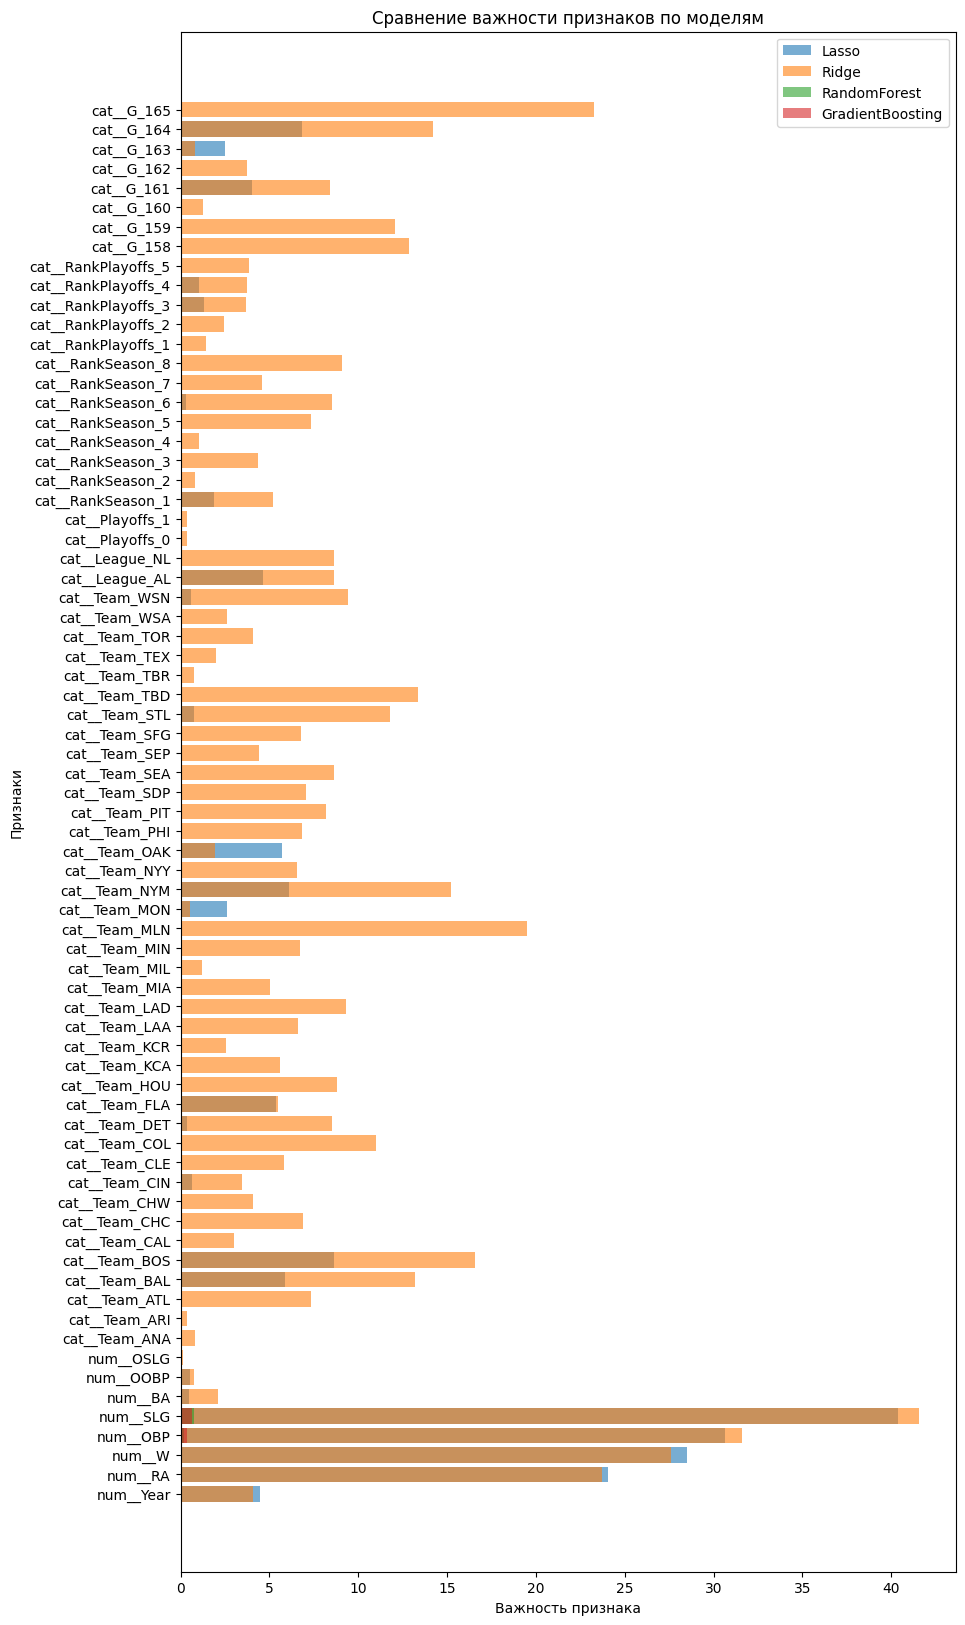

{'Lasso': array([4.46550318e+00, 2.40593637e+01, 2.85185692e+01, 3.06618724e+01,
        4.03520619e+01, 5.03303188e-01, 5.35205952e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.86789044e+00,
        8.62074601e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.63277845e-01, 0.00000000e+00, 0.00000000e+00, 3.65499210e-01,
        5.34647287e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.64084002e+00, 6.10255958e+00,
        0.00000000e+00, 5.72328386e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.61895833e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.78766875e-01, 4.63485080e+00,
        6.09959413e-14, 0.00000000e+00, 0.00000000e+00, 1.87330328e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00,

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def build_pipeline(model, scaling=True, categorical_features=None, numerical_features=None):
    """
    Build a robust pipeline with the given regression model
    
    Keyword arguments:
    regressor -- the regression model
    categorical -- the list of categorical features
    scaling -- whether or not to scale the data
    
    Returns: a pipeline
    """
    
    if categorical_features is None or numerical_features is None:
        raise ValueError("Необходимо указать списки категориальных и числовых признаков")
    
    # Обработка числовых признаков
    num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()) if scaling else ('passthrough', 'passthrough')
    ])
    
    # Обработка категориальных признаков
    cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Объединение обработки признаков
    preprocessor = ColumnTransformer([
        ('num', num_transformer, numerical_features),
        ('cat', cat_transformer, categorical_features)
    ], remainder='passthrough')
    
    # Полный конвейер
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    return pipeline, preprocessor

from sklearn.datasets import fetch_openml

def feature_importance_analysis():
    """
    Анализ важности признаков с использованием Lasso, Ridge, RandomForest и GradientBoosting.
    """
    # Загрузка данных MoneyBall
    moneyball = fetch_openml(data_id=41021, as_frame=True)
    X, y = moneyball.data, moneyball.target
    
    # Определение категориальных и числовых признаков
    categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    
    models = {
        'Lasso': Lasso(alpha=0.1),
        'Ridge': Ridge(alpha=1.0),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    importances = {}
    feature_names = []
    
    for name, model in models.items():
        pipeline, preprocessor = build_pipeline(model, scaling=True, categorical_features=categorical_features, numerical_features=numerical_features)
        pipeline.fit(X, y)
        
        # Получение имен признаков после преобразования
        feature_names = preprocessor.get_feature_names_out()
        
        if hasattr(model, 'coef_'):
            importances[name] = np.abs(model.coef_)
        elif hasattr(model, 'feature_importances_'):
            importances[name] = model.feature_importances_
    
    # Проверяем размерность перед построением графика
    min_length = min(len(feature_names), *[len(v) for v in importances.values()])
    feature_names = feature_names[:min_length]
    
    plt.figure(figsize=(10, 20))
    for name, importance in importances.items():
        plt.barh(feature_names, importance[:min_length], label=name, alpha=0.6)
    
    plt.xlabel('Важность признака')
    plt.ylabel('Признаки')
    plt.title('Сравнение важности признаков по моделям')
    plt.legend()
    plt.show()
    
    return importances

# Запуск анализа важности признаков
feature_importance_analysis()
